In [136]:
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split,KFold
from sklearn.tree import ExtraTreeClassifier,DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,classification_report,f1_score,roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.preprocessing import LabelEncoder
import random

In [289]:
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def model(mod,X_train,y_train,X_test,act=['predict'],scale=False):
    if (scale):
        scale = StandardScaler().fit(X_train)
        X_train = scale.transform(X_train)
        X_test = scale.transform(X_test)
    mod.fit(X_train,y_train)
    d = {}
    for i in act:
        if (i == "predict"):
            pred = mod.predict(X_test)
            d[i] = pred
        elif(i == "prob"):
            prob = mod.predict_proba(X_test)
            d[i] = prob
        elif(i == "importance"):
            imp = mod.feature_importances_
            d["usefulness"] = imp
        elif(i == "params"):
            imp = mod.coef_
            d["usefulness"] = imp
        else:
            pass
    return d

In [3]:
train_ = pd.read_csv("train_data.csv")
test_ = pd.read_csv("test_data.csv")

train_df = train_.copy()
test_df = test_.copy()

In [4]:
traintest = pd.concat([train_df,test_df])

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [5]:
#lets deal with the features one by one,one cell per feature

In [6]:
def duration(s):
    if (s > 0.95):
        return True
    return False

train_df['Less Than A year'] = train_df['Insured_Period'].apply(duration)
test_df['Less Than A year'] = test_df['Insured_Period'].apply(duration)

In [7]:
train_df.Building_Painted = train_df.Building_Painted.map({'N':1,'V':0})
train_df.Building_Fenced = train_df.Building_Fenced.map({'N':1,'V':0})
train_df.Garden = train_df.Garden.map({'V':1,'O':0})
train_df.Settlement = train_df.Settlement.map({'U':1,'R':0})

test_df.Building_Painted = test_df.Building_Painted.map({'N':1,'V':0})
test_df.Building_Fenced = test_df.Building_Fenced.map({'N':1,'V':0})
test_df.Garden = test_df.Garden.map({'V':1,'O':0})
test_df.Settlement = test_df.Settlement.map({'U':1,'R':0})

In [8]:
#drop Geocode For Now
train_df = train_df.drop(['Customer Id','Geo_Code'],axis=1)

#drop Geocode For Now
test_df = test_df.drop(['Customer Id','Geo_Code'],axis=1)

In [9]:
##another means

def Garden(s):
    if (s == 1):
        return 1
    return 0

train_df['Garden'].fillna(train_df[train_df['Garden'].isna()]['Settlement'].apply(Garden),inplace=True)
test_df['Garden'].fillna(test_df[test_df['Garden'].isna()]['Settlement'].apply(Garden),inplace=True)

In [10]:
def doc(s):
    if(s == 1):
        return 1971
    return 1958

train_df['Date_of_Occupancy'].fillna(train_df[train_df['Date_of_Occupancy'].isna()]['Settlement'].apply(doc),inplace=True)
test_df['Date_of_Occupancy'].fillna(test_df[test_df['Date_of_Occupancy'].isna()]['Settlement'].apply(doc),inplace=True)

In [11]:
#frequency encode yearOfObservation
year_encode = traintest.YearOfObservation.value_counts()/len(traintest)
train_df.YearOfObservation = train_df.YearOfObservation.map(year_encode)
test_df.YearOfObservation = test_df.YearOfObservation.map(year_encode)

In [12]:
# #rank this bitch

# from scipy.stats import rankdata

# train_df.check = rankdata(train_df.YearOfObservation)

In [13]:
def workOnbdim(b):
    if(b < 70):
        return np.nan
    return b

train_df['Building Dimension'] = train_df['Building Dimension'].apply(workOnbdim)
test_df['Building Dimension'] = test_df['Building Dimension'].apply(workOnbdim)

In [14]:
m1 = traintest[traintest['Settlement'] == 1]['Building Dimension'].mean()
m2 = traintest[traintest['Settlement'] == 0]['Building Dimension'].mean()
def bdim(s):
    if(s==1):
        return m1
    return m2

train_df['Building Dimension'].fillna(train_df[train_df['Building Dimension'].isna()]['Settlement'].apply(doc),inplace=True)
test_df['Building Dimension'].fillna(test_df[test_df['Building Dimension'].isna()]['Settlement'].apply(doc),inplace=True)

In [15]:
def workOnwind(w):
    if(w == "."):
        return np.nan
    elif(w == ">=10"):
        return "10"
    return w
train_df.NumberOfWindows = train_df.NumberOfWindows.str.lstrip()
train_df.NumberOfWindows = train_df.NumberOfWindows.apply(workOnwind)
train_df['Missing NOW'] = train_df.NumberOfWindows.isna()

test_df.NumberOfWindows = test_df.NumberOfWindows.str.lstrip()
test_df.NumberOfWindows = test_df.NumberOfWindows.apply(workOnwind)
test_df['Missing NOW'] = test_df.NumberOfWindows.isna()

In [16]:
def now(b):
    if(b <= 100):
        return "1"
    if(b <= 300 and b > 100):
        return "2"
    if(b > 300 and b <= 800 ):
        return "3"
    if(b > 800 and b <= 2500):
        return "4"
    if(b > 2500 and b <= 6000):
        return "5"
    if(b > 6000 and b <= 15000):
        return str(random.randint(5,9))
    if(b > 15000):
        return str(random.randint(9,11))

train_df['NumberOfWindows'].fillna(train_df[train_df['NumberOfWindows'].isna()]['Building Dimension'].apply(now),inplace=True)
test_df['NumberOfWindows'].fillna(test_df[test_df['NumberOfWindows'].isna()]['Building Dimension'].apply(now),inplace=True)

train_df.NumberOfWindows = train_df.NumberOfWindows.astype('int16')
test_df.NumberOfWindows = test_df.NumberOfWindows.astype('int16')

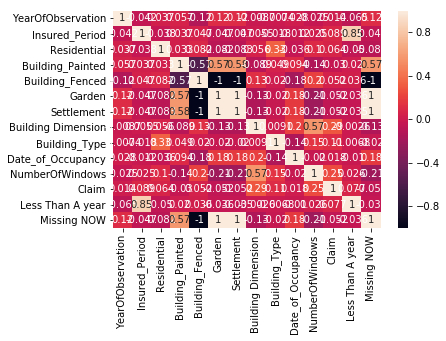

In [62]:
sb.heatmap(train_df.corr(),annot=True)

In [43]:
#train the model normally

In [17]:
X = train_df.drop(['Settlement','Garden','Missing NOW'],axis=1)
y = train_df.Claim

In [18]:
val = KFold(n_splits=5)

In [19]:
# s = []
# for x,x2 in val.split(X):
#     X_train,X_test = X.iloc[x],X.iloc[x2]
#     y_train,y_test = y.iloc[x],y.iloc[x2]
#     mod_test = model(RandomForestClassifier(n_estimators=100),X_train,y_train,X_test,act=['predict'])
#     v = f1_score(y_test,mod_test['predict'])
#     s.append(v)

In [178]:
X_train,X_test = train_test_split(X,random_state=10,test_size=0.3)

In [179]:
# top = SelectKBest(chi2,k=5)
# top.fit(X_train,y_train)

# X_train = top.transform(X_train)
# X_test = top.transform(X_test)

In [180]:
#since the data is not balanced,let me try to oversample the minority class

X0 = X_train[X_train['Claim']==1]
X1 = X_train[X_train['Claim']==0]
Xt0 = X0.append(X0)
Xt = Xt0.append(X1)
#shuffle
X_train = Xt.sample(frac=1)

In [181]:
y_train = X_train.Claim
X_train = X_train.drop('Claim',axis=1)

y_test = X_test.Claim
X_test = X_test.drop('Claim',axis=1)

In [66]:
top = SelectKBest(chi2,k=5)
top.fit(X_train,y_train)

X_train = top.transform(X_train)
X_test = top.transform(X_test)

In [306]:
mod_test = model(GradientBoostingClassifier(),X_train,y_train,X_test,act=['predict'])

In [307]:
pred1 = mod_test['predict']

In [308]:
mod_test = model(AdaBoostClassifier(),X_train,y_train,X_test,act=['predict'])

In [309]:
pred2 = mod_test['predict']

In [310]:
mod_test = model(XGBClassifier(),X_train,y_train,X_test,act=['predict','importance'])

In [311]:
pred3 = mod_test['predict']

In [312]:
mod_test = model(RandomForestClassifier(n_estimators=200,max_depth=9),X_train,y_train,X_test,act=['predict','importance'])

In [313]:
pred4 = mod_test['predict']

In [314]:
mod_test = model(SVC(C=10.0),X_train,y_train,X_test,act=['predict'],scale=True)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype bool, int16, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype bool, int16, int64, float64 were all converted to float64 by StandardScaler.
  """


In [315]:
pred5 = mod_test['predict']

In [184]:
# treealgs = [GradientBoostingClassifier(),AdaBoostClassifier(),XGBClassifier(),RandomForestClassifier(n_estimators=200,max_depth=9)]
# nontreealgs = [SVC(10.0)]
# preds = []


# for alg in treealgs:
#     mod_test = model(alg,X_train,y_train,X_test,act=['predict'])
#     preds.append(mod_test['predict'])

    
# for alg in nontreealgs:
#     mod_test = model(alg,X_train,y_train,X_test,act=['predict'],scale=True)
#     preds.append(mod_test['predict'])

In [185]:
# param_grid = {
#     "n_estimators":[50,100,200],
#     "max_depth":[3,5,7,9],
#     "booster":["gbtree","gblinear","dart"],
#     "learning_rate":[0.1,0.01]
# }

# grid = GridSearchCV(XGBClassifier(),param_grid,cv=10,scoring='roc_auc',verbose=1)
# grid.fit(X_train,y_train)

In [156]:
#DecisionTreeBestEstimator has a max deth of 9,minsamspkit of 2
#RandomForestBestEstimator has a max depth of 9,estimator of 200
#Xgboost best estimator max dep

In [366]:
roc_auc_score(y_test,pred)

0.6534177810655575

In [364]:
ensemble = np.vstack((pred2,pred3,pred5)) #,pred3,pred4,pred5

In [365]:
pred = ensemble.max(axis=0)

In [239]:
pred = np.round(np.mean(ensemble,axis=0))

In [367]:
#since the data is not balanced,let me try to undersample the dominating class

X0 = train_df[train_df['Claim']==1]
X1 = train_df[train_df['Claim']==0]
Xt0 = X0.append(X0)
Xt0 = Xt0.append(Xt0)
Xt = Xt0.append(X1)
#shuffle
X_t = Xt.sample(frac=1)

In [75]:
#transformation

In [368]:
X_transformed = X_t.drop(['Claim','Settlement','Missing NOW','Garden'],axis=1)
X_test_transformed = test_df.drop(['Garden','Settlement','Missing NOW'],axis=1)

In [369]:
ytrain = X_t.Claim

In [109]:
X_transformed = X_transformed[top6]
X_test_transformed = X_test_transformed[top6]

In [370]:
mod_d = model(AdaBoostClassifier(),X_transformed,ytrain,X_test_transformed,act=['predict'])

In [371]:
pred1 = mod_d['predict']

In [372]:
mod_d = model(XGBClassifier(),X_transformed,ytrain,X_test_transformed,act=['predict'])

In [373]:
pred2 = mod_d['predict']

In [374]:
mod_d = model(GradientBoostingClassifier(),X_transformed,ytrain,X_test_transformed,act=['predict'])

In [375]:
pred3 = mod_d['predict']

In [376]:
mod_d = model(RandomForestClassifier(n_estimators=200,max_depth=9),X_transformed,ytrain,X_test_transformed,act=['predict'])

In [377]:
pred4 = mod_d['predict']

In [378]:
mod_d = model(SVC(C=10.0),X_transformed,ytrain,X_test_transformed,act=['predict'],scale=True)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype bool, int16, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype bool, int16, int64, float64 were all converted to float64 by StandardScaler.
  """


In [379]:
pred5 = mod_d['predict']

In [380]:
ensemble = np.vstack((pred1,pred2,pred5))

In [381]:
pred = ensemble.max(axis=0)

In [54]:
# param_grid = {
#     'max_depth':[3,5,7],
#     'n_estimators':[10,100],
#     'learning_rate':[0.1,0.01],
#     'min_child_weight':[1,2]
# }

# grid = GridSearchCV(XGBClassifier(),param_grid,scoring='roc_auc',cv=10)
# grid.fit(X_transformed,y)

In [384]:
test_ = pd.read_csv("test_data.csv")
test_['Claim'] = pred4
fin = test_[['Customer Id','Claim']]

fin.to_csv("submit/sub43.csv",index=False)

#### 